(1024, 1280)


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …
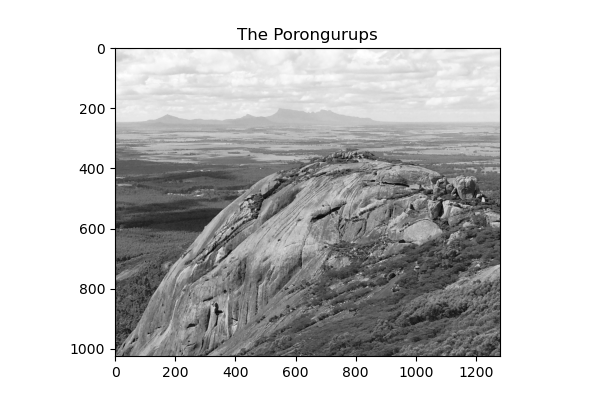

In [7]:
import numpy as np
import skimage
from matplotlib import pyplot as plt
from skimage import color, io

%matplotlib widget

# define a standard data type
float_type = np.float32

# Read in the image
im_col = io.imread("images/Porongorups.JPG")
image = color.rgb2gray(im_col).astype(float_type)[747:1771, 1175:2455]
print(image.shape)

# Plot the image
[fig, ax] = plt.subplots(1, 1, figsize=(6, 4))
ax.imshow(image, cmap=plt.get_cmap("Greys_r"))
ax.set_title("The Porongurups")
plt.show()

# Get the filter
filtr = np.zeros((3,3), dtype=float_type) - 1.0
filtr[1,1] = 8.0

In [10]:
# Write images to file

# Number of images to write
nimages = 1024
images_in = np.zeros((nimages, *image.shape), dtype=image.dtype)
for n in range(0, nimages):
    images_in[n,:,:] = image[:]

# Write out the images to file
images_in.tofile("images_in.dat")

# Write out the filter to file
filtr.tofile("image_kernel.dat")

In [ ]:
import time

import numpy as np
from scipy.signal import correlate

def xcor2d_naive(padded_im, filtr, pad_l, pad_r):
    """Naive 2D cross-correlation algorithm."""
    padded_shape = padded_im.shape
    orig_shape = image.shape
    filtered_im = np.zeros(orig_shape).astype(float_type)
    # Loop over all the rows and columns of the filtered image
    # and compute the cross-correlation at each point
    for x0 in range(0, orig_shape[0]):
        for x1 in range(0, orig_shape[1]):
            # Get the relevant portion of the padded image
            im_section = padded_im[
                x0 : (x0 + pad_l + pad_r + 1), x1 : (x1 + pad_l + pad_r + 1)
            ]

            # Set the portion of the filtered image
            filtered_im[x0, x1] = np.sum(im_section * filtr)

    return filtered_im


def xcor2d_slicing(padded_im, filtr, pad_l, pad_r):
    """2D cross correlation that uses the full Numpy array."""
    im_shape = (padded_im.shape[0] - pad_l - pad_r, padded_im.shape[1] - pad_l - pad_r)
    result = np.zeros(im_shape, dtype=float_type)
    for x in range(0, filtr.shape[0]):
        for y in range(0, filtr.shape[1]):
            result = (
                result
                + filtr[x, y]
                * padded_im[
                    x : x + im_shape[0], y : y + im_shape[1]
                ]
            )
    return result

def xcor2d_fft(padded_im, filtr, pad_l, pad_r):
    """2D cross-correlation in the Fourier domain."""
    im_shape = (padded_im.shape[0] - pad_l - pad_r, padded_im.shape[1] - pad_l - pad_r)
    
    # Pad the filter with zero
    scratch = np.zeros(padded_im.shape, dtype=float_type)

    # Pad the filter with zeros
    scratch[0 : filtr.shape[0], 0 : filtr.shape[1]] = filtr[:, :]

    fft_scratch = np.fft.fftn(scratch)
    fft_im = np.fft.fftn(padded_im)

    # Use the correlation theorem
    # to turn the cross-correlation
    # into a convolution by multiplying by the complex conjugate of the FFT
    result = fft_im * np.conj(fft_scratch)
    return np.fft.ifftn(result).real.astype(float_type)[
        0 : im_shape[0], 0 : im_shape[1]
    ]


def xcor2d_scipy(im, filtr):
    """A canned Scipy function."""
    return correlate(im, filtr, mode="valid", method="direct")